# CREATE A CUSTOM MODEL

In [1]:
!git clone https://github.com/deltat1995/AN2DL_Project1

Cloning into 'AN2DL_Project1'...
remote: Enumerating objects: 1365, done.
remote: Counting objects: 100% (1365/1365), done.
remote: Compressing objects: 100% (1357/1357), done.
remote: Total 3447 (delta 7), reused 1360 (delta 6), pack-reused 2082
Receiving objects: 100% (3447/3447), 124.78 MiB | 31.87 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [22]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [23]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

<tf.Tensor: id=1020456, shape=(), dtype=float32, numpy=-1870.5908>

<tf.Tensor: id=1020491, shape=(), dtype=float32, numpy=1739.5483>

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
4.419589374999987
GPU (s):
0.21105937599986646
GPU speedup over CPU: 20x


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [24]:
%tensorflow_version 2.x
import os
import tensorflow as tf
import numpy as np

SEED = 345
tf.random.set_seed(SEED)  

cwd = os.getcwd()
cwd
cwd = os.path.join(cwd,'AN2DL_Project1')
cwd

'/content'

'/content/AN2DL_Project1'

## CREATE A GENERATORS

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        brightness_range=(0.5,1.),
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant', 
                                        cval=0,
                                        rescale=1./255)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

valid_data_gen = ImageDataGenerator(rescale=1./255)

## IMPORT TRAINING AND VALIDATION DATA

In [26]:
dataset_dir = os.path.join(cwd, 'newDataset')

bs = 5

img_h=256
img_w=256

num_classes= 20

classes = [ 'owl',    # 0
            'galaxy', # 1
            'lightning', # 2
            'wine-bottle', # 3
            't-shirt', # 4
            'waterfall', # 5
            'sword', # 6
            'school-bus', # 7
            'calculator', # 8
            'sheet-music', # 9
            'airplanes', # 10
            'lightbulb', # 11
            'skyscraper', # 12
            'mountain-bike', # 13
            'fireworks', # 14
            'computer-monitor', # 15
            'bear', # 16
            'grand-piano', # 17
            'kangaroo', # 18
            'laptop']       # 19


# Training
training_dir = os.path.join(dataset_dir, 'training')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(img_h,img_w),
                                               batch_size=bs, 
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors
validation_dir = os.path.join(dataset_dir, 'validation')
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               target_size=(img_h,img_w),
                                               batch_size=bs, 
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=SEED)  # targets are directly converted into one-hot vectors


class_indices = train_gen.class_indices
class_indices

Found 1244 images belonging to 20 classes.
Found 310 images belonging to 20 classes.


{'airplanes': 10,
 'bear': 16,
 'calculator': 8,
 'computer-monitor': 15,
 'fireworks': 14,
 'galaxy': 1,
 'grand-piano': 17,
 'kangaroo': 18,
 'laptop': 19,
 'lightbulb': 11,
 'lightning': 2,
 'mountain-bike': 13,
 'owl': 0,
 'school-bus': 7,
 'sheet-music': 9,
 'skyscraper': 12,
 'sword': 6,
 't-shirt': 4,
 'waterfall': 5,
 'wine-bottle': 3}

## TEST THE GENERATORS (SKIP THIS CODE)

Using TensorFlow backend.


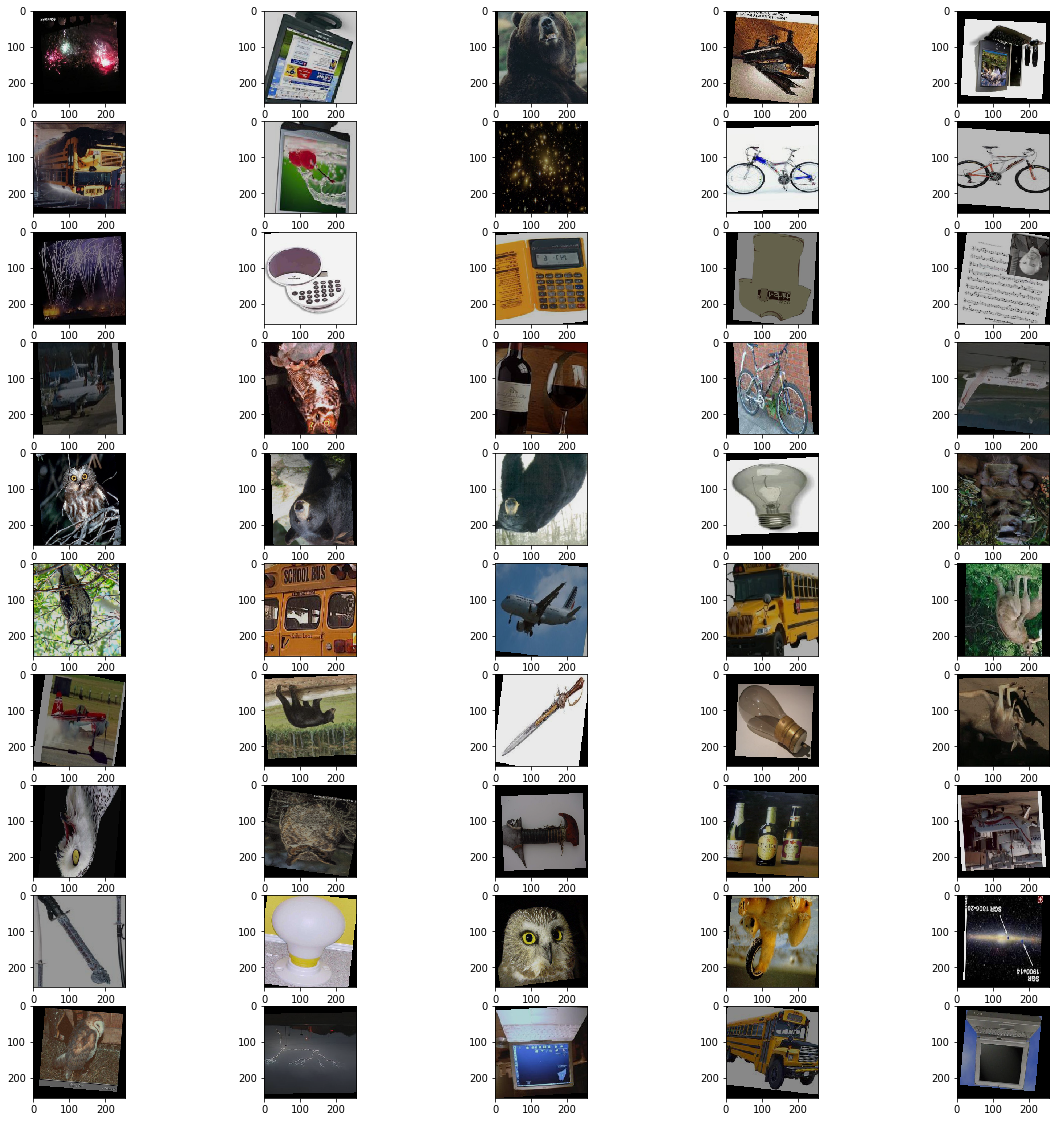

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import *

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                              output_types=(tf.float32,tf.float32),
                                              output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
num_row=10

fig, ax = plt.subplots(num_row, bs, figsize=(20, 20))
ax = ax.ravel()

iterator = iter(train_dataset)

for row in range(num_row):
    augmented_img, target = next(iterator)
    for col in range(0,5):
    #augmented_img = augmented_img[0]   # First element
    #augmented_img = augmented_img * 255  # denormalize
        _ = ax[bs*row+col].imshow(augmented_img[col]) 

## CREATE A MODEL AND INITIALIZE IT

In [0]:
from tensorflow.keras import layers
depth = 5
start_f = 32


model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(img_h, img_w, 3)))
for i in range(depth):
    model.add(layers.Conv2D(filters=start_f,
                                             kernel_size=(3, 3),
                                             strides=(1, 1), 
                                             padding='same'))
   
    model.add(layers.ReLU())  # we can specify the activation function directly in Conv2D
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    start_f *= 2
    
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(rate=0.1))
model.add(layers.Dense(units=num_classes, activation='softmax'))    

_ = tf.keras.utils.plot_model(model,'model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=False)

In [27]:
import json

json_file = open('/content/drive/My Drive/CNN_Nov22_19-26-09/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/CNN_Nov22_19-26-09/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = ['accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## SET CHECKPOINTS AND TRAINING THE MODEL

In [42]:
import os
from datetime import datetime
import shutil
cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
shutil.rmtree(exps_dir, ignore_errors=True)
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'),
                                                   monitor='val_acc',
                                                   save_weights_only=False,
                                                   save_best_only=True,
                                                   save_freq=5) 
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)


history = model.fit_generator(train_gen,
                            validation_data = valid_gen,
                            callbacks=callbacks, 
                            epochs = 100)

Epoch 1/100
249/249 [==============================] - 36s 144ms/step - loss: 2.9727 - accuracy: 0.0635 - val_loss: 2.9336 - val_accuracy: 0.0645
Epoch 2/100
249/249 [==============================] - 34s 138ms/step - loss: 2.9088 - accuracy: 0.1005 - val_loss: 2.7511 - val_accuracy: 0.1194
Epoch 3/100
249/249 [==============================] - 34s 138ms/step - loss: 2.7478 - accuracy: 0.1616 - val_loss: 2.5702 - val_accuracy: 0.2290
Epoch 4/100
249/249 [==============================] - 35s 140ms/step - loss: 2.6167 - accuracy: 0.1905 - val_loss: 2.4137 - val_accuracy: 0.2258
Epoch 5/100
249/249 [==============================] - 35s 139ms/step - loss: 2.5064 - accuracy: 0.2484 - val_loss: 2.3592 - val_accuracy: 0.3032
Epoch 6/100
249/249 [==============================] - 35s 139ms/step - loss: 2.4180 - accuracy: 0.2814 - val_loss: 2.1044 - val_accuracy: 0.3968
Epoch 7/100
249/249 [==============================] - 35s 139ms/step - loss: 2.3040 - accuracy: 0.2966 - val_loss: 2.1571 -

In [47]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

5844

In [5]:
import json
with open('file.json', 'w') as f:
    json.dump(history.history, f)

NameError: ignored

## VISUALIZE THE RESULT OF PERFORMANCE

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## TEST THE MODEL AND SAVE THE RESULTS

In [0]:
from datetime import datetime

def create_csv(results, results_dir='./output/'):
    if not os.path.exists(results_dir):
      os.makedirs(results_dir)
    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [32]:
import os
from PIL import Image
import numpy as np

image_filenames = next(os.walk('./AN2DL_Project1/startDataset/test'))[2]                          
results = {}

for image_name in image_filenames:
    img = Image.open('./AN2DL_Project1/startDataset/test/'+image_name).convert('RGB')
    img = img.resize((img_w,img_h))
    img_array = np.array(img)
    img_array = img_array*1./255 #normalization
    img_array = np.expand_dims(img_array,0) #needed for fixed dim of input in the model
    output = model.predict(img_array)
    prediction = np.where(output == np.max(output))[1]  
    print('Image: '+str(image_name)+ ' Class: '+ list(class_indices.keys())[int(prediction)])
    results[image_name] = int(prediction)
    
create_csv(results)

Image: IMG_261.jpg Class: wine-bottle
Image: IMG_2010.jpg Class: laptop
Image: IMG_708.jpg Class: airplanes
Image: IMG_1808.jpg Class: airplanes
Image: IMG_1551.jpg Class: airplanes
Image: IMG_999.jpg Class: wine-bottle
Image: IMG_674.jpg Class: airplanes
Image: IMG_385.jpg Class: galaxy
Image: IMG_497.jpg Class: wine-bottle
Image: IMG_1202.jpg Class: airplanes
Image: IMG_1929.jpg Class: wine-bottle
Image: IMG_2021.jpg Class: airplanes
Image: IMG_917.jpg Class: galaxy
Image: IMG_1235.jpg Class: airplanes
Image: IMG_897.jpg Class: galaxy
Image: IMG_1058.jpg Class: galaxy
Image: IMG_1756.jpg Class: laptop
Image: IMG_1209.jpg Class: airplanes
Image: IMG_815.jpg Class: airplanes
Image: IMG_1882.jpg Class: galaxy
Image: IMG_1982.jpg Class: galaxy
Image: IMG_775.jpg Class: galaxy
Image: IMG_1977.jpg Class: airplanes
Image: IMG_512.jpg Class: galaxy
Image: IMG_24.jpg Class: airplanes
Image: IMG_58.jpg Class: airplanes
Image: IMG_1657.jpg Class: airplanes
Image: IMG_183.jpg Class: airplanes
Im